In [1]:
import math
import numpy as np
from lib import FastGradientMethod
from lib import SinkhornMethod
from lib import NesterovsLinearCoupling
from lib import DualGradientDescent
from lib import Experiments

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def fastgrad(C, p, q, gamma=0.1, eps=0.01, log=False):
    fgm = FastGradientMethod(gamma, n=p.shape[0], epsilon=eps, log=log)
    x, iterations_num = fgm.fit(C, p, q)
    return x, iterations_num, 0

def coupling(C, p, q, gamma=0.1, eps=0.01, log=False):
    fgm = NesterovsLinearCoupling(gamma, n=p.shape[0], epsilon=eps, log=log)
    x, iterations_num = fgm.fit(C, p, q)
    return x, iterations_num, 0

def grad(C, p, q, gamma=0.1, eps=0.01, log=False):
    fgm = DualGradientDescent(gamma, n=p.shape[0], epsilon=eps)
    x, iterations_num = fgm.fit(C, p, q)
    return x, iterations_num, 0

def sinkhorn(C, p, q, gamma=0.1, eps=0.01, log=False):
    sm = SinkhornMethod(gamma, n=p.shape[0], epsilon=eps, log=log)
    x, inner_iterations_num, outer_iterations_num = sm.fit(C, p, q, with_prox=False)
    return x, inner_iterations_num, outer_iterations_num

In [3]:
def B(u, v, C, gamma):
    try:
        K = np.exp(-C/ gamma)
    except:
        K = 0
    return np.matmul(np.matmul(np.diag(np.exp(u)), K), np.diag(np.exp(v)))

In [4]:
def sinkhorn(C, r, c, epsilon, gamma=0.5):  
    u = np.zeros(len(C))
    v = np.zeros(len(C))    
    
    k = 0
    while True:
        if k % 2 == 0:
            u = u + np.log(r) - np.log(B(u, v, C, gamma).sum(1))
            
        else:
            v = v + np.log(c) - np.log(B(u, v, C, gamma).sum(0))
        
        k += 1
        
        if np.abs(B(u, v, C, gamma).sum(1) - r).sum() +\
           np.abs(B(u, v, C, gamma).sum(0) - c).sum() <= epsilon:
            break
            
    return B(u, v, C, gamma), k, 0

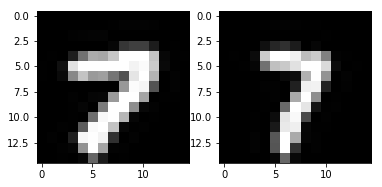

In [5]:
problems = []

for i in range(10, 16, 1):
    (C, p, q) = Experiments.load_data('test_data/1.png', 'test_data/2.png', show=i==15, size=i)
    problems.append((C, p, q))

In [6]:
x, inner_iterations_num, _ = sinkhorn(*problems[0], gamma=1, epsilon=0.1)

In [7]:
epsilon = 0.01
epsilons, gammas, iterations = Experiments.test([problems[0]], 
                                                config={'eps': (epsilon, epsilon, 1), 
                                                        'gamma': (1, 0.05, 1.5)},
                                                methods=[fastgrad, sinkhorn, coupling, grad])

 19%|█▉        | 6/32 [09:58<43:11, 99.67s/it]


KeyboardInterrupt: 

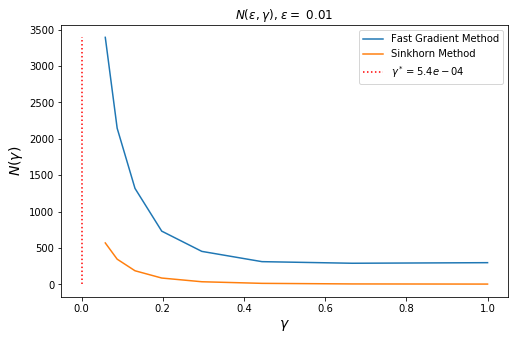

In [8]:
Experiments.plot_algorithm_comparation(gammas, iterations[:, :, 0], epsilon, problems[0][1].shape[0], 
                                       methods_names=["Fast Gradient Method", "Sinkhorn Method"])
plt.savefig('plots/fgm_sinkhorn.png', dpi=1000)